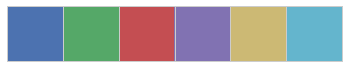

In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [6]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)

In [7]:
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [8]:
df=df[df.Method=='Tully-Fisher'] # choose a method

In [9]:
mainfl=np.isfinite(df.err)&(df.err!=0)
df1=df[mainfl] # database of reported errors
len(df1)

56395

In [10]:
namelist=list(df1['Galaxy ID']) # galaxy names from database of reported errors
counter=collections.Counter(namelist)

In [11]:
meas=np.array(list(counter.values())) # convert Nmeas to np array
len(meas) # number of individual galaxies with reported errors

11376

In [12]:
names=np.array(list(counter.keys())) # convert list of names to np array

In [13]:
len(names[meas>1])

9100

In [14]:
df1=df1[np.in1d(df1['Galaxy ID'],names[meas>1])]

In [20]:
%%time
np.random.seed(10)
nbins=5000 # 5e3 -> 2 minutes, 1e4 destroys memory
bootp50=[] # mean error from the bootstrap for each galaxy
#bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
ecf=[]
eqd=[]
gal=[]
for i in names[meas>1]:
    dfilter=np.in1d(df1['Galaxy ID'],i)
    dummy=df1[dfilter]
    gal+=[i]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tli)
    booterr=(np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0))/2 # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
############## This block should be ran for 10k draws ###############
#    mymed=np.median(tli,axis=0) #median for error of m error
#    mst=[np.median(np.abs(tli[:,kk]-mymed[kk])) for kk in range(nbins)]
#    bootmsig+=[(np.percentile(mst, 84,axis=0)-np.percentile(mst, 16,axis=0))/2e6] # error of m error
#    bootmother+=[np.median(mst)/1e6]
#####################################################################
    bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
#    bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
#    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
#    distwav=10**(avnat/5+1)/1e6
#    wsti=0.461*distwav*wnat # weighted standard deviation
#    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
#    ecf+=[ecfi]
#    eqd+=[np.sqrt(ecfi**2+wsti**2)]  

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


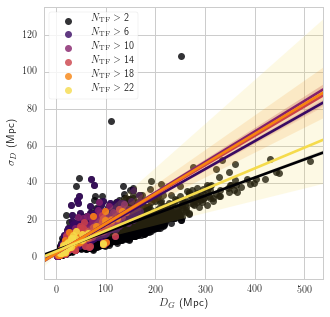

In [34]:
from matplotlib.pyplot import cm
color=cm.inferno(np.linspace(0,1,12))
plt.figure(figsize=(5,5))
for i in range(2,24,4):
    filt=(np.array(meas[meas>1])>i)
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    sns.regplot(x,y,color=color[(i-2)//2],label='$N_\mathrm{TF}>$ '+str(i))
                #current_palette[(i-2)//2]) # green, quadrature 
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/relerrTF.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/relerrTF.png', dpi=reso,transparent=True)